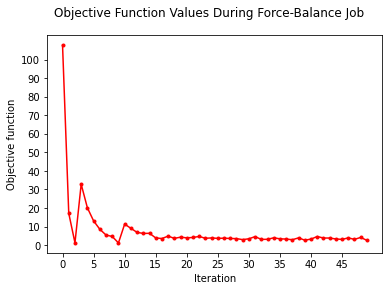

[1.2, 1.233922720459, 1.2652110816820001, 1.199961793425, 1.2107638820039999, 1.219788220868, 1.227324025679, 1.23361456175, 1.238864074076, 1.243243770798, 1.243581261295, 1.243452114363, 1.243366764731, 1.2433111092559999, 1.243275472707, 1.243253235839, 1.243239885812, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346, 1.243237408346]
[0.85, 0.8492436946135, 0.8502198801485, 0.849949672044, 0.8499944944435, 0.8500319122512, 0.850063138977, 0.8500891924464, 0.8501109252831, 0.8501290508863, 0.8502682708241, 0.850244669493, 0.850225

/var/folders/2h/qwnkzrws279__yz86krh0l_h0000gn/T/ipykernel_24281/1397975728.py:137: RuntimeWarning: invalid value encountered in true_divide
  plt.quiver(pos_x, pos_y, u/norm, v/norm, color='k', angles="xy", zorder=5, pivot="mid")


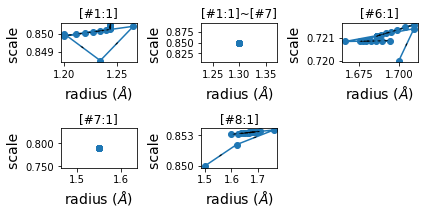

In [79]:
import pickle, gzip, json, os
import numpy as np
import matplotlib.pyplot as plt
import simtk.unit as simtk_unit
from openff.toolkit.typing.engines.smirnoff import ForceField
from matplotlib import patheffects
from matplotlib.ticker import FuncFormatter
from datetime import datetime



#To use, place ForceBalance result directories of format "iter_0000", "iter_0001", etc in this notebook's directory
#Leave the rest of the directory empty



#Count the folders in the current directory.
folders = 0
path = os.getcwd()
for _, dirnames, filenames in os.walk(path):
    
    folders += len(dirnames)
    
    #If the notebook creates a checkpoints directory, don't count it as a FB results directory
    if '.ipynb_checkpoints' in dirnames:
        folders -= 1
    
    
#Plot the value of the objective function across all iterations
def plot_objective(savefig=False, author=None):
    
    #Obj is the value of the objective function
    obj = []
    
    #Open all objective.p files
    for i in range(folders):
        with gzip.open(f"iter_{str(i).rjust(4,'0')}/objective.p",'rb') as f:

            temp_dict = pickle.load(f)
            obj.append(temp_dict['X'])
    
    #Create plot
    plt.plot(obj, 'r.-')
    
    #Cosmetic options
    plt.xticks(np.arange(0, folders, step=5))
    plt.yticks(np.arange(0, max(obj), step=10))
    suptitle = "Objective Function Values During Force-Balance Job"
    plt.suptitle(suptitle)
    title = ""
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function")

    #If requested, save the figure
    if savefig:
        now = datetime.now()
        plt.savefig('objective_results.png', dpi=400, transparent=False, facecolor='white', metadata={'title':title, 'author':author, 'date':str(now)})

    plt.show()
    
    
    
#Plot the values of all properties across all iterations
def plot_properties(savefig=False, author=None):
    
    values = []

    for i in range(0,folders):
        with open(f"iter_{str(i).rjust(4,'0')}/results.json","r") as f:

            temp_dict = json.load(f)
            num_properties = len(temp_dict["estimated_properties"]["properties"])

            if i == 0:
                for j in range(0, num_properties):
                    values.append([])

            for j in range(0, num_properties):

                #Add values of each property to a list inside the master list "values"
                values[j].append(temp_dict["estimated_properties"]["properties"][j]["value"]["value"])

    #For debugging, uncomment this line and view the dictionary:
    #print(json.dumps(temp_dict,indent=4))
    
    
    #Subplot layout
    figure, axis = plt.subplots(num_properties)
    
    for i in range(0,num_properties):

        axis[i].plot(values[i], 'r.-')
        axis[i].set_title(temp_dict["estimated_properties"]["properties"][i]["substance"]["components"][1]["smiles"] + " in " + temp_dict["estimated_properties"]["properties"][i]["substance"]["components"][0]["smiles"])

    #If requested, save the figure
    if savefig:
        now = datetime.now()
        title = ""
        plt.savefig('property_results.png', dpi=400, transparent=False, facecolor='white', metadata={'title':title, 'author':author, 'date':str(now)})

    plt.tight_layout()
    plt.show()


    
def plot_parameters(savefig=False, author=None):

    atom_type = ['[#1:1]', '[#1:1]~[#7]', '[#6:1]', '[#7:1]', '[#8:1]']
    radius = {'[#1:1]':[], '[#1:1]~[#7]':[], '[#6:1]':[], '[#7:1]':[], '[#8:1]':[]}
    scale = {'[#1:1]':[], '[#1:1]~[#7]':[], '[#6:1]':[], '[#7:1]':[], '[#8:1]':[]}
    
    
    for i in range(0,folders):    
        force_field = ForceField(
                f"iter_{str(i).rjust(4,'0')}/openff-2.0.0-GBSA_OBC2-tagged.offxml", allow_cosmetic_attributes=True
            )
        
        for atype in atom_type:
                
            radius[atype].append(force_field.get_parameter_handler("GBSA")[atype].radius.value_in_unit(simtk_unit.angstrom))
            scale[atype].append(force_field.get_parameter_handler("GBSA")[atype].scale)

    plt.figure(figsize=(18,12))

    #Code by Jeffry Setiadi (github.com/jeff231li):
    for i, atype in enumerate(atom_type):
        
        ax = plt.subplot(3,3,i+1)
        u = np.diff(radius[atype])
        v = np.diff(scale[atype])
        pos_x = radius[atype][:-1] + u/2
        pos_y = scale[atype][:-1] + v/2
        norm = np.sqrt(u**2+v**2) 

        plt.plot(radius[atype], scale[atype], "o-",label=atype)
        plt.quiver(pos_x, pos_y, u/norm, v/norm, color='k', angles="xy", zorder=5, pivot="mid")

        def format_tick_labels(x, pos):
            return '{0:.3f}'.format(x)

        ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
        plt.ylabel("scale ", fontsize=14)
        plt.xlabel("radius ($\AA$)", fontsize=14)
        plt.title(f"{atype}")
        plt.tight_layout()

    #If requested, save the figure
    if savefig:
        now = datetime.now()
        title = "Parameter Results"
        plt.savefig('parameter_results.png', dpi=500, transparent=False, facecolor='white', metadata={'title':title, 'author':author, 'date':str(now)})    
        
    
    plt.show()
    
    
plot_objective()
plot_parameters(savefig=True)